In [1]:
from __future__ import unicode_literals,print_function,division
from io import open
import glob
import os


In [2]:
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


In [3]:
all_letters = string.ascii_letters+".,;'"
n_letters = len(all_letters)

In [4]:
def unicodeToAscii(s):
    return ''.join(
    c for c in unicodedata.normalize('NFD',s)
    if unicodedata.category(c)!= 'Mn'
    and c in all_letters)

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [5]:
category_lines = {}
all_category = []

def readLines(filename):
    lines = open(filename,encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_category.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
n_categories = len(all_category) #category_lines : a dictionary mapping each category(lang) to a list of lines(names)
#all_categories : list of all lang
#n_categories : no. of lang

In [9]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## Turning Names into Tensors

In [12]:
import torch
def letterToIndex(letter): #find letter index from all_letters
    return all_letters.find(letter)

def letterToTensor(letter): #demo
    tensor = torch.zeros(1,n_letters)
    tensor[0][letterToIndex(letter)]=1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line),1,n_letters)
    for li,letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)]=1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
torch.Size([5, 1, 56])


In [13]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN,self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size+hidden_size,hidden_size) #i2h index to hidden 
        self.i2o = nn.Linear(input_size+hidden_size,output_size) #i2o index to output
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self,input,hidden):
        combined = torch.cat((input,hidden),1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output,hidden
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters,n_hidden,n_categories)

In [15]:
input = letterToTensor('A')
hidden = torch.zeros(1,n_hidden)

output,next_hidden = rnn(input,hidden)
print(output)

tensor([[-2.8055, -2.8875, -2.9674, -3.0147, -2.8735, -2.9541, -2.8286, -3.0267,
         -2.8137, -2.9488, -2.8266, -2.9179, -2.8012, -2.8861, -2.8040, -2.9528,
         -2.8543, -2.9081]], grad_fn=<LogSoftmaxBackward>)


In [16]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8055, -2.8875, -2.9674, -3.0147, -2.8735, -2.9541, -2.8286, -3.0267,
         -2.8137, -2.9488, -2.8266, -2.9179, -2.8012, -2.8861, -2.8040, -2.9528,
         -2.8543, -2.9081]], grad_fn=<LogSoftmaxBackward>)


In [17]:
def categoryFromOutput(output):
    top_n,top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_category[category_i],category_i
print(categoryFromOutput(output))

('Italian', 12)


In [20]:
import random

def randomChoice(l):
    return l[random.randint(0,len(l)-1)]

def randomTrainingExample():
    category = randomChoice(all_category)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_category.index(category)],dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category,line,category_tensor,line_tensor

for i in range(10):
    category,line,category_tensor,line_tensor = randomTrainingExample()
    print('category =',category,'/ line =',line)

category = Russian / line = Haidakin
category = Greek / line = Vamvakidis
category = Russian / line = Vagner
category = English / line = Boland
category = Portuguese / line = Gouveia
category = Czech / line = Fremut
category = Irish / line = Damhain
category = Portuguese / line = Franco
category = French / line = Charpentier
category = Korean / line = Ri


In [21]:
criterion = nn.NLLLoss()

In [22]:
learning_rate = 0.005
def train(category_tensor,line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i],hidden)
        
    loss = criterion(output,category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate,p.grad.data)
    return output,loss.item()

In [24]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m,s)

start = time.time()

for iter in range(1,n_iters+1):
    category,line,category_tensor,line_tensor = randomTrainingExample()
    output,loss = train(category_tensor,line_tensor)
    current_loss+=loss
    
    if iter%print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
    
    if iter % plot_every == 0:
        all_losses.append(current_loss/plot_every)
        current_loss =0


5000 5% (0m 8s) 2.7034 Abel / German ✗ (Spanish)
10000 10% (0m 15s) 1.9843 Thomson / Russian ✗ (Scottish)
15000 15% (0m 23s) 0.8989 Xing / Chinese ✓
20000 20% (0m 30s) 0.0626 Malihoudis / Greek ✓
25000 25% (0m 37s) 0.6840 Jackson / Scottish ✓
30000 30% (0m 44s) 0.3547 Kanaan / Arabic ✓
35000 35% (0m 52s) 1.0375 Guerin / French ✓
40000 40% (0m 59s) 0.9143 Fakhoury / Arabic ✓
45000 45% (1m 7s) 3.2122 Ross / Greek ✗ (Scottish)
50000 50% (1m 15s) 1.8229 Vives / Portuguese ✗ (Spanish)
55000 55% (1m 23s) 0.0561 Grzeskiewicz / Polish ✓
60000 60% (1m 30s) 6.5469 Zaloumi / Italian ✗ (Greek)
65000 65% (1m 37s) 0.2487 Makuda / Japanese ✓
70000 70% (1m 46s) 1.5974 Tornincasa / Dutch ✗ (Italian)
75000 75% (1m 53s) 0.8116 Rheem / Korean ✓
80000 80% (2m 0s) 0.3477 Beaumont / French ✓
85000 85% (2m 7s) 1.6858 Stoep / Arabic ✗ (Dutch)
90000 90% (2m 14s) 0.8630 Castillo / Italian ✗ (Spanish)
95000 95% (2m 21s) 1.7781 Schoonraad / French ✗ (Dutch)
100000 100% (2m 28s) 0.0817 Sheng / Chinese ✓


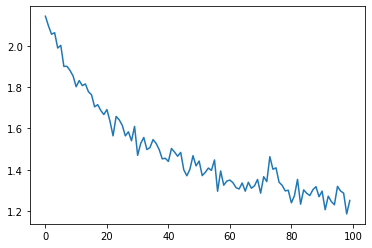

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

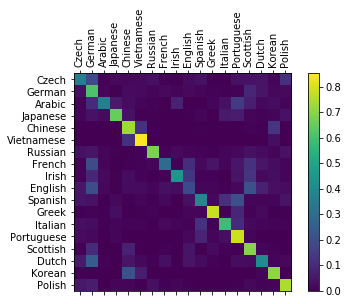

In [29]:
confusion = torch.zeros(n_categories,n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output,hidden = rnn(line_tensor[i],hidden)
        
    return output


for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_category.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i]/confusion[i].sum()
    
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_category, rotation=90)
ax.set_yticklabels([''] + all_category)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()